# WSU size of computing estimate numbers (Database)

The goal here is to put together some numbers on the type of projects ALMA would process as part of the WSU to be used to produce a total size of computing estimate.

Amanda Kepley (20220921)

In [1]:
import numpy as np
import astropy.units as u
from ast import literal_eval
from astropy import constants as const
from matplotlib import pyplot as plt, ticker as mticker
import re
import math
from astropy.table import Table, QTable, vstack, join, unique
from importlib import reload
import pickle
import pandas as pd

## Read in massaged cycle 7 and 8 data <a id="readin"></a>

In [2]:
cycle7tab = Table.read('data/result_table_cycle7_with_calc_values_20220923.csv')
cycle8tab = Table.read('data/result_table_cycle8_with_calc_values_20220923.csv')

In [3]:
cycle7tab.columns

<TableColumns names=('obs_publisher_did','facility_name','instrument_name','obs_id','dataproduct_type','calib_level','target_name','s_ra','s_dec','s_fov','s_resolution','t_min','t_max','t_exptime','t_resolution','em_min','em_max','em_res_power','pol_states','o_ucd','access_url','access_format','proposal_id','data_rights','gal_longitude','gal_latitude','band_list','em_resolution','bandwidth','antenna_arrays','is_mosaic','spatial_resolution','frequency_support','frequency','velocity_resolution','publication_year','proposal_abstract','schedblock_name','sensitivity_10kms','cont_sensitivity_bandwidth','pwv','group_ous_uid','member_ous_uid','asdm_uid','type','scan_intent','science_observation','spatial_scale_max','qa2_passed','science_keyword','scientific_category','collections','array','points_per_fov','spw_freq','spw_specwidth','spw_nchan','pb','cell','imsize','spw_nchan_max','mitigated','failed_mitigation_nbin1','failed_mitigation_nbin2','ntarget')>

In [4]:
cycle8tab.columns

<TableColumns names=('obs_publisher_did','facility_name','instrument_name','obs_id','dataproduct_type','calib_level','target_name','s_ra','s_dec','s_fov','s_resolution','t_min','t_max','t_exptime','t_resolution','em_min','em_max','em_res_power','pol_states','o_ucd','access_url','access_format','proposal_id','data_rights','gal_longitude','gal_latitude','band_list','em_resolution','bandwidth','antenna_arrays','is_mosaic','spatial_resolution','frequency_support','frequency','velocity_resolution','publication_year','proposal_abstract','schedblock_name','sensitivity_10kms','cont_sensitivity_bandwidth','pwv','group_ous_uid','member_ous_uid','asdm_uid','type','scan_intent','science_observation','spatial_scale_max','qa2_passed','science_keyword','scientific_category','collections','array','points_per_fov','spw_freq','spw_specwidth','spw_nchan','pb','cell','imsize','spw_nchan_max','mitigated','failed_mitigation_nbin1','failed_mitigation_nbin2','ntarget')>

## Put together WSU mous data base <a id="wsu_db"></a>

In [5]:
import wsu_db

In [6]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [7]:
reload(wsu_db)
result = wsu_db.create_database(cycle7tab)

In [10]:
result['proposal_id','gous','mous','schedblock_name']

proposal_id,gous,mous,schedblock_name
str14,str22,str22,str18
2019.1.01326.S,uid://A001/X1465/X1001,uid://A001/X1465/X1002,Position_i_03_7M
2019.1.01326.S,uid://A001/X1465/X1007,uid://A001/X1465/X1008,Position_j_03_7M
2019.1.01326.S,uid://A001/X1465/X100d,uid://A001/X1465/X100e,Position_k_03_7M
2019.1.01326.S,uid://A001/X1465/X1013,uid://A001/X1465/X1014,Position_l_03_7M
2019.1.01326.S,uid://A001/X1465/X1019,uid://A001/X1465/X101a,Position_m_03_7M
2019.1.01326.S,uid://A001/X1465/X101f,uid://A001/X1465/X1020,Position_n_03_7M
2019.1.01326.S,uid://A001/X1465/X1025,uid://A001/X1465/X1026,Position_o_03_7M
2019.1.01326.S,uid://A001/X1465/X102b,uid://A001/X1465/X102c,Position_p_03_7M
...,...,...,...


In [11]:
result_c8 = wsu_db.create_database(cycle8tab)

In [12]:
idx = (result['band'] == 3) & (result['wsu_chanavg_stepped2'] <= 3)
result[idx]['mous','band','blc_freq','wsu_freq','blc_velres','wsu_velres_stepped2','wsu_chanavg_stepped2'].show_in_browser(jsviewer=True)

Text(0.5, 1.0, 'new velres calc with min nbin -- band 3 only')

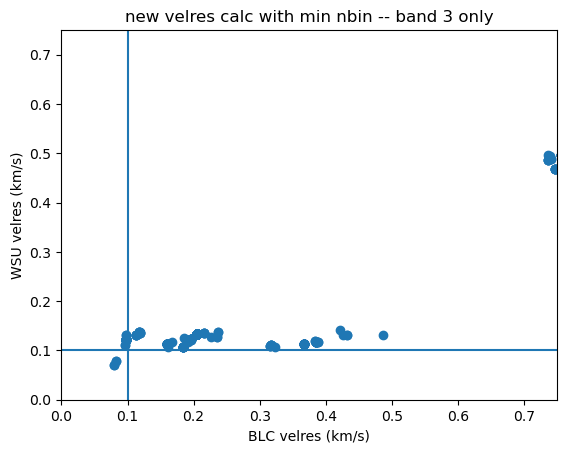

In [14]:
idx = (result['band'] == 3)
plt.scatter(result[idx]['blc_velres'],result[idx]['wsu_velres_stepped2'])
plt.xlabel('BLC velres (km/s)')
plt.ylabel('WSU velres (km/s)')
plt.xlim(0,0.75)
plt.ylim(0,0.75)
plt.axvline(0.1)
plt.axhline(0.1)
plt.title('new velres calc with min nbin -- band 3 only')

(0.0, 0.75)

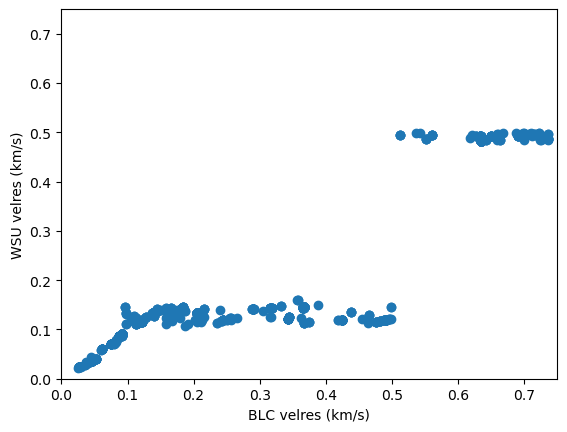

In [15]:
plt.scatter(result_c8['blc_velres'],result_c8['wsu_velres_stepped2'])
plt.xlabel('BLC velres (km/s)')
plt.ylabel('WSU velres (km/s)')
plt.xlim(0,0.75)
plt.ylim(0,0.75)

In [16]:
result_c8.columns

<TableColumns names=('mous','proposal_id','gous','schedblock_name','array','science_keyword','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','target_name','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nchan_agg_st

In [17]:
np.unique(result_c8['wsu_tint'])

<Quantity [3.072, 9.984] s>

In [18]:
# save data bases if what's desired
result.write('data/cycle7wsu_20240315_gous.ecsv',overwrite=True)
result_c8.write('data/cycle8wsu_20240315_gous.ecsv',overwrite=True)

In [19]:
len(result)

11519

In [20]:
len(result_c8)

10843

## Adding in L80, BLC tint, and BLC ntunings info

In [21]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [22]:
# data on L80 obtained from archive
result_L80 = wsu_db.add_l80(result,l80_file='data/cycle7_L80.csv')

In [23]:
result_c8_L80 = wsu_db.add_l80(result_c8,l80_file='data/cycle8_L80.csv')

In [24]:
len(result_L80)

11519

In [25]:
len(result_c8_L80)

10843

In [26]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [27]:
# data on BLC tint obtained from Richard Simon from OT SBs
result_L80_tint = wsu_db.add_blc_tint_from_db(result_L80,
                                              'data/SB_MetaData_C7_C8_2023Jan27.csv')

In [28]:
result_c8_L80_tint = wsu_db.add_blc_tint_from_db(result_c8_L80,
                                              'data/SB_MetaData_C7_C8_2023Jan27.csv')

In [29]:
len(result_L80_tint)

11519

In [30]:
len(result_c8_L80_tint)

10843

In [31]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [32]:
# data on multi-tuning projects obtained from Richard Simon from spreadsheet listing multi-tuning projects
wsu_db.add_blc_ntunings(result_L80_tint,'data/Cycle7_SBs_MultiFreqSpecSetup_clean.csv')

Match found for 2019.1.01600.S, AS2COS00_a_03_TM1
Match found for 2019.1.01365.S, 9io9_a_04_TM1
Match found for 2019.1.00571.S, S255IR_N_a_06_TM1
Match found for 2019.1.00571.S, S255IR_N_b_06_TM1
Match found for 2019.1.00571.S, S255IR_N_d_06_TM1
Match found for 2019.1.00486.S, SPT0112-_a_03_TM1
Match found for 2019.1.00486.S, SPT0457-_a_03_TM1
Match found for 2019.1.00486.S, SPT2340-_a_03_TM1
Match found for 2019.1.00377.S, V883_Ori_a_06_TM1
Match found for 2019.1.00377.S, V883_Ori_b_06_TM1
Match found for 2019.1.00377.S, V883_Ori_c_06_TM1
Match found for 2019.1.00092.S, BrickMas_a_04_TM1
Match found for 2019.1.00092.S, BrickMas_a_06_TM1
Match found for 2019.1.00092.S, BrickMas_b_06_TM1


In [33]:
#idx = (result_L80_tint['blc_ntunings'] > 1) 
#result_L80_tint['proposal_id','mous','blc_nspw','blc_ntunings'][idx].show_in_browser()

In [34]:
wsu_db.add_blc_ntunings(result_c8_L80_tint,'data/Cycle8_SBs_MultiFreqSpecSetup_clean.csv')

Match found for 2021.1.00018.S, AR1635_a_03_TM1
Match found for 2021.1.00018.S, AR231_a_03_TM1
Match found for 2021.1.00018.S, AR2482_a_03_TM1
Match found for 2021.1.00018.S, AR1693_a_03_TM1
Match found for 2021.1.00018.S, AR2598_a_03_TM1
Match found for 2021.1.00018.S, AR2170_a_03_TM1
Match found for 2021.1.00018.S, AR1872_a_03_TM1
Match found for 2021.1.00246.S, AS2COS00_a_03_TM1
Match found for 2021.1.00246.S, AS2COS01_a_03_TM1
Match found for 2021.1.00452.S, V883_Ori_a_07_TM1
Match found for 2021.1.00917.S, V4334_Sg_a_06_TM1
Match found for 2021.1.00917.S, V4334_Sg_b_06_TM1
Match found for 2021.1.00917.S, V4334_Sg_a_07_TM1
Match found for 2021.1.00917.S, V4334_Sg_b_07_TM1
Match found for 2021.1.01056.S, S255IR_N_a_06_TM1
Match found for 2021.1.01056.S, S255IR_N_b_06_TM1
Match found for 2021.1.01056.S, S255IR_N_c_06_TM1
Match found for 2021.1.01164.S, IRAS_162_c_06_TM1
Match found for 2021.1.01543.S, ACT-S_J0_a_03_TM1
Match found for 2021.1.01543.S, ACT-S_J0_b_03_TM1
Match found for

In [35]:
#idx = result_c8_L80_tint['blc_ntunings'] > 1
#result_c8_L80_tint['proposal_id','mous','blc_nspw','blc_ntunings'][idx].show_in_browser()

## Adding in calibration TOS information

This is needed to get the total number of visibilities and the data volume. Also necessary to start refine the data rates.

In [36]:
import large_cubes
from importlib import reload

In [37]:
reload(large_cubes)
# tos information from Felix from archive metadata. Note that it does include QA0 fails for both cases.

# this source file only had the time on source per pointing, not the total time on source over the whole mosaic 
#tos_db = large_cubes.calc_time_on_source('data/project_mous_band_array_eb_size___source_intent_inttime')

# this source file has the time on source over the whole mosaic. 
tos_db = large_cubes.calc_time_on_source('data/files_from_felix_202303/source_asdm_scan_sumint')

Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS PHASE WVR
Intent not recognized: BANDPASS PHASE WVR
project_id list greater than 1. This shouldn't happen. MOUS: uid://A002/X445835/X6
made it to table creation


In [38]:
tos_db.columns

<TableColumns names=('proposal_id','mous','band','array','bp_time','flux_time','phase_time','pol_time','check_time','target_time','target_name','target_time_tot','ntarget','time_tot','cal_time')>

In [39]:
len(tos_db)

24884

In [40]:
tos_db

proposal_id,mous,band,array,bp_time,flux_time,phase_time,pol_time,check_time,target_time,target_name,target_time_tot,ntarget,time_tot,cal_time
,,,,s,s,s,s,s,s,,s,,s,s
str14,str22,float64,str6,float64,float64,float64,float64,float64,float64,str35,float64,float64,float64,float64
2019.1.01326.S,uid://A001/X1465/X1002,3.0,7m,1209.6,0.0,362.88,0.0,0.0,1995.84,Position_8,1995.84,1.0,3568.3199999999997,1572.48
2019.1.01326.S,uid://A001/X1465/X1008,3.0,7m,604.8,0.0,120.96,0.0,0.0,393.12,Position_2,393.12,1.0,1118.88,725.76
2019.1.01326.S,uid://A001/X1465/X100e,3.0,7m,604.8,0.0,120.96,0.0,0.0,393.12,Position_3,393.12,1.0,1118.88,725.76
2019.1.01326.S,uid://A001/X1465/X1014,3.0,7m,604.8,0.0,120.96,0.0,0.0,393.12,Position_4,393.12,1.0,1118.88,725.76
2019.1.01326.S,uid://A001/X1465/X101a,3.0,7m,604.8,0.0,120.96,0.0,0.0,393.12,Position_5,393.12,1.0,1118.88,725.76
2019.1.01326.S,uid://A001/X1465/X1020,3.0,7m,604.8,0.0,120.96,0.0,0.0,393.12,Position_6,393.12,1.0,1118.88,725.76
2019.1.01326.S,uid://A001/X1465/X1026,3.0,7m,604.8,0.0,120.96,0.0,0.0,393.12,Position_7,393.12,1.0,1118.88,725.76
2019.1.01326.S,uid://A001/X1465/X102c,3.0,7m,604.8,0.0,120.96,0.0,0.0,393.12,Position_7,393.12,1.0,1118.88,725.76


In [41]:
tos_db.write('data/tos_db_20231212.ecsv',overwrite=True)

In [42]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [43]:
result_tos = wsu_db.add_tos_to_db(result_L80_tint,tos_db)

In [44]:
result_c8_tos = wsu_db.add_tos_to_db(result_c8_L80_tint,tos_db)

In [45]:
result_tos.write('data/result_tos_20240315_gous.ecsv',overwrite=True)
result_c8_tos.write('data/result_c8_tos_20240315_gous.ecsv',overwrite=True)

In [46]:
result_tos

mous,proposal_id,gous,schedblock_name,array,science_keyword,scientific_category,nant_typical,nant_array,nant_all,band,ntarget,target_name,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_nchan_agg_finest_early,wsu_nchan_agg_finest_later_2x,wsu_nchan_agg_finest_later_4x,wsu_nchan_agg_stepped_early,wsu_nchan_agg_stepped_later_2x,wsu_nchan_agg_stepped_later_4x,wsu_nchan_agg_stepped2_early,wsu_nchan_agg_stepped2_later_2x,wsu_nchan_agg_stepped2_later_4x,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,L80,Project,SB_name,blc_tint,blc_ntunings,bp_time,flux_time,phase_time,pol_time,check_time,target_time,target_time_tot,time_tot,cal_time
,,,,,,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,,,,,,,,m,,,s,,s,s,s,s,s,s,s,s,s
str22,str14,str22,str18,str6,str105,str27,int64,int64,int64,float64,float64,str35,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,str26,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
uid://A001/X1465/X1002,2019.1.01326.S,uid://A001/X1465/X1001,Position_i_03_7M,7m,"Outflows, jets, feedback, Galactic centres/nuclei",Active galaxies,10,12,16,3.0,1.0,Position_8,0.13050363616709187,12.418751976046456,T,220.0,108.514167152526,2.483750395209291,2,4,965.2043680983645,92.45001476575733,2.9778920543263903,14336.0,4096.0,2.0,8.0,92.45001476575733,2,16.0,16.0,32.0,2.0,8,8,16,958.5,71.0,3.108177664666337,297.0,22.0,0.9630973045444989,607.5,45.0,1.9699717592955657,9.984,2086.0,6734.0,3292.0,16688.0,16688.0,33376.0,53872.0,53872.0,107744.0,26336.0,26336.0,52672.0,0.17306649480305175,0.17306649480305175,0.3461329896061035,0.02163331185038147,45.0,66.0,120.0,30.03768,2019.1.01326.S,Position_i_03_7M,10.08,1.0,1209.6,0.0,362.88,0.0,0.0,1995.84,1995.84,3568.3199999999997,1572.48
uid://A001/X1465/X1008,2019.1.01326.S,uid://A001/X1465/X1007,Position_j_03_7M,7m,"Outflows, jets, feedback, Galactic centres/nuclei",Active galaxies,10,12,16,3.0,1.0,Position_2,0.13352956949867897,11.495155000772085,T,240.0,99.33587941322293,2.299031000154417,2,4,1116.9672480031732,100.94947251671041,3.1673235453701216,8192.0,2048.0,2.0,8.0,100.94947251671041,2,16.0,16.0,32.0,2.0,8,8,16,1107.0,82.0,3.2874887082848767,324.0,24.0,0.9621918170589883,661.5,49.0,1.9644749598287679,9.984,1806.0,6172.0,3023.0,14448.0,14448.0,28896.0,49376.0,49376.0,98752.0,24184.0,24184.0,48368.0,0.15849513227869003,0.15849513227869003,0.31699026455738005,0.019811891534836253,45.0,66.0,120.0,30.609047,2019.1.01326.S,Position_j_03_7M,10.08,1.0,604.8,0.0,120.96,0.0,0.0,393.12,393.12,1118.88,725.76
uid://A001/X1465/X100e,2019.1.01326.S,uid://A001/X1465/X100d,Position_k_03_7M,7m,"Outflows, jets, feedback, Galactic centres/nuclei",Active galaxies,10,12,16,3.0,1.0,Position_3,0.1335711696824279,11.477738486513816,T,240.0,99.3358716017038,2.295547697302763,2,4,1116.9768029798806,100.9494845484696,3.1673495625218457,8192.0,2048.0,2.0,8.0,100.9494845484696,2,16.0,16.0,32.0,2.0,8,8,16,1107.0,82.0,3.2874883164624453,324.0,24.0,0

In [47]:
result_tos.columns

<TableColumns names=('mous','proposal_id','gous','schedblock_name','array','science_keyword','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','target_name','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nchan_agg_st

In [48]:
result_c8_tos

mous,proposal_id,gous,schedblock_name,array,science_keyword,scientific_category,nant_typical,nant_array,nant_all,band,ntarget,target_name,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_nchan_agg_finest_early,wsu_nchan_agg_finest_later_2x,wsu_nchan_agg_finest_later_4x,wsu_nchan_agg_stepped_early,wsu_nchan_agg_stepped_later_2x,wsu_nchan_agg_stepped_later_4x,wsu_nchan_agg_stepped2_early,wsu_nchan_agg_stepped2_later_2x,wsu_nchan_agg_stepped2_later_4x,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,L80,Project,SB_name,blc_tint,blc_ntunings,bp_time,flux_time,phase_time,pol_time,check_time,target_time,target_time_tot,time_tot,cal_time
,,,,,,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,,,,,,,,m,,,s,,s,s,s,s,s,s,s,s,s
str22,str14,str22,str26,str6,str105,str27,int64,int64,int64,float64,float64,str35,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,str26,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
uid://A001/X158f/X111,2021.1.01571.S,uid://A001/X158f/X110,G09v1.40_a_08_TM1,12m,"Outflows, jets, feedback",Active galaxies,47,50,66,8.0,1.0,G09v1.40,0.004000240613311581,0.45833271459124353,F,240.0,14.397483872538897,0.0916665429182487,2,4,31176.314691250842,404.3315523311515,22.83384100374022,512.0,128.0,2.0,8.0,404.3315523311515,2,16.0,16.0,32.0,2.0,8,8,16,31171.5,2309.0,23.112172549159283,13486.5,999.0,9.999593060463459,13486.5,999.0,9.999593060463459,3.072,64.0,148.0,148.0,512.0,512.0,1024.0,1184.0,1184.0,2368.0,1184.0,1184.0,2368.0,0.03957148510363061,0.03957148510363061,0.07914297020726122,0.004946435637953826,1081.0,1225.0,2145.0,191.52359,2021.1.01571.S,G09v1.40_a_08_TM1,2.016,1.0,———,———,———,———,———,———,———,———,———
uid://A001/X158f/X115,2021.1.01571.S,uid://A001/X158f/X114,SPT0125-_a_07_TM1,12m,"Outflows, jets, feedback",Active galaxies,47,50,66,7.0,1.0,SPT0125-47,0.0045375135989717905,0.2911647419354411,F,430.0,16.331349317037823,0.05823294838708822,2,4,31160.819141109412,356.47101883940036,25.85577672790684,512.0,128.0,2.0,8.0,356.47101883940036,2,8.0,16.0,32.0,2.0,4,8,16,31158.0,2308.0,26.203906945300194,11880.0,880.0,9.991091036336297,11880.0,880.0,9.991091036336297,3.072,64.0,168.0,168.0,256.0,512.0,1024.0,672.0,1344.0,2688.0,672.0,1344.0,2688.0,0.022442217115002588,0.044884434230005175,0.08976886846001035,0.005610554278750647,1081.0,1225.0,2145.0,341.9766,2021.1.01571.S,SPT0125-_a_07_TM1,2.016,1.0,302.4,0.0,90.72,0.0,0.0,453.6,453.6,846.72,393.12
uid://A001/X158f/X13a,2021.1.01543.S,uid://A001/X158f/X139,ACT-S_J0_a_03_TM1,12m,"Sub-mm Galaxies (SMG), Gravitational lenses",Galaxy evolution,47,50,66,3.0,1.0,ACT-S_J0007.5+1606,0.016370669248356715,3.2510106691183673,F,140.0,59.27082942119824,0.6502021338236735,2,20,7727.466820763161,98.80399468281071,20.998292318707925,4800.0,240.0,1.875,37.5,98.80399468281071,2,16.0,16.0,32.0,2.0,8,8,16,7722.0,572.0,23.430200045127812,3294.0,244.0,9.994700718551027,3294.0,244.0,9.994700718551027,3.072,259.0,607.0,607.0,207

In [49]:
result_c8_tos.columns

<TableColumns names=('mous','proposal_id','gous','schedblock_name','array','science_keyword','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','target_name','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x','wsu_nchan_agg_st

## Adding in data rates

In [50]:
reload(large_cubes)
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [51]:
len(result_tos)

11519

In [52]:
wsu_db.add_rates_to_db(result_tos)

In [53]:
wsu_db.add_rates_to_db(result_c8_tos)

## adding cycle information

In [54]:
cycle_info = np.full(len(result_tos),'cycle7')
result_tos['cycle_info'] = cycle_info

In [55]:
cycle_info = np.full(len(result_c8_tos),'cycle8')
result_c8_tos['cycle_info'] = cycle_info

## fix up science categories

In [56]:
reload(wsu_db)
wsu_db.fix_scientific_categories(result_tos)

In [57]:
wsu_db.fix_scientific_categories(result_c8_tos)

In [58]:
np.unique(result_tos['scientific_category_proposal'])

"Circumstellar disks, exoplanets and the solar system"
Cosmology and the high redshift Universe
Galaxies and galactic nuclei
"ISM, star formation and astrochemistry"
Stellar evolution and the Sun


# creating per mous version of data base

This is going to be more useful for the DMGs as well as for combining with mitigation information (which is per MOUS). But I don't think the fractions of time are going to be useful, so I'll leave them off and recalculate.

I think that the path forward uses the group_by function and aggregation to get values.

In [82]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [59]:
result_tos_mous = wsu_db.create_per_mous_db(result_tos)

Taking first value. Key aggregation not specified: mous
Taking first value. Key aggregation not specified: proposal_id
Taking first value. Key aggregation not specified: gous
Taking first value. Key aggregation not specified: schedblock_name
Taking first value. Key aggregation not specified: array
Taking first value. Key aggregation not specified: science_keyword
Taking first value. Key aggregation not specified: scientific_category_proposal
Taking first value. Key aggregation not specified: scientific_category
Taking first value. Key aggregation not specified: nant_typical
Taking first value. Key aggregation not specified: nant_array
Taking first value. Key aggregation not specified: nant_all
Taking first value. Key aggregation not specified: band
Taking first value. Key aggregation not specified: ntarget
Taking first value. Key aggregation not specified: target_name
Taking first value. Key aggregation not specified: mosaic
Taking first value. Key aggregation not specified: blc_npol
T

In [60]:
result_tos_mous.columns

<TableColumns names=('mous','proposal_id','gous','schedblock_name','array','science_keyword','scientific_category_proposal','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x',

Double-checking that I got the BLC productsize right. 

In [61]:
idx = result_tos['ntarget'] > 10
result_tos[idx]['mous','proposal_id','schedblock_name','ntarget','blc_productsize']

mous,proposal_id,schedblock_name,ntarget,blc_productsize
,,,,Gbyte
str22,str14,str18,float64,float64
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,22.7432576
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,23.3013536
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,23.3013536
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,23.3013536
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,23.3013536
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,23.3013536
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,23.8662144
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,23.8662144


In [62]:
idx = result_tos_mous['mous'] == 'uid://A001/X1465/X11b6'
result_tos_mous[idx]['mous','proposal_id','schedblock_name','ntarget','blc_productsize']

mous,proposal_id,schedblock_name,ntarget,blc_productsize
,,,,Gbyte
str22,str14,str18,float64,float64
uid://A001/X1465/X11b6,2019.1.01291.S,1_a_06_TM1,30.0,705.3014303999998


In [63]:
30*23

690

Looks like I did. The individual BLC product size times the number of targets is now the per mous blc_productsize

In [64]:
result_tos_mous

mous,proposal_id,gous,schedblock_name,array,science_keyword,scientific_category_proposal,scientific_category,nant_typical,nant_array,nant_all,band,ntarget,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_nchan_agg_finest_early,wsu_nchan_agg_finest_later_2x,wsu_nchan_agg_finest_later_4x,wsu_nchan_agg_stepped_early,wsu_nchan_agg_stepped_later_2x,wsu_nchan_agg_stepped_later_4x,wsu_nchan_agg_stepped2_early,wsu_nchan_agg_stepped2_later_2x,wsu_nchan_agg_stepped2_later_4x,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,L80,Project,SB_name,blc_tint,blc_ntunings,bp_time,flux_time,phase_time,pol_time,check_time,target_time_tot,time_tot,cal_time,mfssize,wsu_cubesize_stepped2,wsu_productsize_early_stepped2,wsu_datarate_early_stepped2_typical,wsu_visrate_early_stepped2_typical,wsu_datavol_early_stepped2_typical_target_tot,wsu_datavol_early_stepped2_typical_cal,wsu_datavol_early_stepped2_typical_total,wsu_nvis_early_stepped2_typical_target_tot,wsu_nvis_early_stepped2_typical_cal,wsu_nvis_early_stepped2_typical_total,blc_datarate_typical,blc_visrate_typical,blc_datavol_typical_target_tot,blc_datavol_typical_cal,blc_datavol_typical_total,blc_nvis_typical_target_tot,blc_nvis_typical_cal,blc_nvis_typical_total,wsu_datarate_early_stepped2_array,wsu_visrate_early_stepped2_array,wsu_datavol_early_stepped2_array_target_tot,wsu_datavol_early_stepped2_array_cal,wsu_datavol_early_stepped2_array_total,wsu_nvis_early_stepped2_array_target_tot,wsu_nvis_early_stepped2_array_cal,wsu_nvis_early_stepped2_array_total,blc_datarate_array,blc_visrate_array,blc_datavol_array_target_tot,blc_datavol_array_cal,blc_datavol_array_total,blc_nvis_array_target_tot,blc_nvis_array_cal,blc_nvis_array_total,wsu_productsize_later_2x_stepped2,wsu_datarate_later_2x_stepped2_typical,wsu_visrate_later_2x_stepped2_typical,wsu_datavol_later_2x_stepped2_typical_target_tot,wsu_datavol_later_2x_stepped2_typical_cal,wsu_datavol_later_2x_stepped2_typical_total,wsu_nvis_later_2x_stepped2_typical_target_tot,wsu_nvis_later_2x_stepped2_typical_cal,wsu_nvis_later_2x_stepped2_typical_total,wsu_datarate_later_2x_stepped2_array,wsu_visrate_later_2x_stepped2_array,wsu_datavol_later_2x_stepped2_array_target_tot,wsu_datavol_later_2x_stepped2_array_cal,wsu_datavol_later_2x_stepped2_array_total,wsu_nvis_later_2x_stepped2_array_target_tot,wsu_nvis_later_2x_stepped2_array_cal,wsu_nvis_later_2x_stepped2_array_total,wsu_productsize_later_4x_stepped2,wsu_datarate_later_4x_stepped2_typical,wsu_visrate_later_4x_stepped2_typical,wsu_datavol_later_4x_stepped2_typical_target_tot,wsu_datavol_later_4x_stepped2_typical_cal,wsu_datavol_later_4x_stepped2_typical_total,wsu_nvis_later_4x_stepped2_typical_target_tot,wsu_nvis_later_4x_stepped2_typical_cal,wsu_nvis_later_4x_stepped2_typical_total,wsu_datarate_later_4x_stepped2_array,wsu_visrate_later_4x_stepped2_array,wsu_datavol_later_4x_stepped2_array_target_tot,wsu_datavol_later_4x_stepped2_array_cal,wsu_datavol_later_4x_stepped2_array_total,wsu_nvis_later_4x_stepped2_array_target_tot,wsu_nvis_later_4x_stepped2_array_cal,wsu_nvis_later_4x_stepped2_array_total,blc_cubesize,blc_cubesize_sum,blc_productsize,cycle_info
,,,,,,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,,,,,,,,m,,,s,,s,s,s,s,s,s,s,s,Gbyte,Gbyte,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gv

In [65]:
len(result_tos_mous)

2719

In [66]:
result_tos_mous.columns

<TableColumns names=('mous','proposal_id','gous','schedblock_name','array','science_keyword','scientific_category_proposal','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x',

In [67]:
result_c8_tos_mous = wsu_db.create_per_mous_db(result_c8_tos)

Taking first value. Key aggregation not specified: mous
Taking first value. Key aggregation not specified: proposal_id
Taking first value. Key aggregation not specified: gous
Taking first value. Key aggregation not specified: schedblock_name
Taking first value. Key aggregation not specified: array
Taking first value. Key aggregation not specified: science_keyword
Taking first value. Key aggregation not specified: scientific_category_proposal
Taking first value. Key aggregation not specified: scientific_category
Taking first value. Key aggregation not specified: nant_typical
Taking first value. Key aggregation not specified: nant_array
Taking first value. Key aggregation not specified: nant_all
Taking first value. Key aggregation not specified: band
Taking first value. Key aggregation not specified: ntarget
Taking first value. Key aggregation not specified: target_name
Taking first value. Key aggregation not specified: mosaic
Taking first value. Key aggregation not specified: blc_npol
T

In [68]:
len(result_c8_tos_mous)

2481

## Apply mitigations to per mous database

Commented the following out since I don't think it makes too much sense right now

In [69]:
#reload(wsu_db)

In [70]:
#wsu_db.apply_mitigations(result_tos_mous)

In [71]:
#wsu_db.apply_mitigations(result_c8_tos_mous)

## Adding in current mitigation information

In [72]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [73]:
c7_pickle = '/Users/akepley/Dropbox/Support/naasc/WSU/mitigation/weblog_stats/allc7_stats.20220930.pkl'
c7_astropy = wsu_db.get_pipeinfo(c7_pickle)

In [74]:
c7_astropy

mous,project,plversion,procedure,nant,totaltime,imgtime,cubetime,aggtime,fctime,nEB,npt,nscan,reptgt,nscience,nspw,webpredrms,webcontrms,webcontBW,webfreq,webbm,webdirtyDR,webDRcorr,webcontpk,webfreqline,webbmline,webpredrmsline,webdirtyDRline,webDRcorrline,weblinerms,weblinepk,weblineBW,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,prodsizeaftercube,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw
str22,str14,str4,str20,int64,float64,float64,float64,float64,float64,int64,int64,int64,str35,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,str64,str7,str7,str846,str54
uid://A001/X1465/X1002,2019.1.01326.S,C7,hifa_calimage,10,5.1194444444444445,4.113333333333333,3.731666666666667,0.06194444444444445,0.16666666666666666,1,34,2,Position_8,1,4,0.0019,0.0025,2.76,92.6159,13.628499550574158,54.0,2.5,0.105,85.9,15.461953304805961,0.079,38.0,2.5,0.074,3.49,1.8727352000000002,40.0,60.0,1.68,1.68,350.0,11.7,11.7,11.7,False,default,default,default,default,default
uid://A001/X1465/X1008,2019.1.01326.S,C7,hifa_calimage,10,1.9755555555555557,1.267777777777778,0.9855555555555555,0.05583333333333334,0.10694444444444444,1,39,1,Position_2,1,4,0.0014,0.0017,6.65,100.8709,12.991420245685227,6.9,1.5,0.0171,93.9,14.877499789951266,0.085,25.0,2.5,0.077,2.14,1.863162,40.0,60.0,0.86,0.86,350.0,6.88,6.88,6.88,False,default,default,default,default,default
uid://A001/X1465/X100e,2019.1.01326.S,C7,hifa_calimage,10,2.3316666666666666,1.5105555555555559,1.1925000000000001,0.06055555555555556,0.12555555555555556,1,39,1,Position_3,1,4,0.0013,0.0016,6.51,100.8724,13.053160536820192,12.0,2.0,0.0174,93.9,14.458215657542254,0.076,34.0,2.5,0.073,3.27,1.8709740000000001,40.0,60.0,0.839,0.839,350.0,6.71,6.71,6.71,False,default,default,default,default,default
uid://A001/X1465/X1014,2019.1.01326.S,C7,hifa_calimage,9,2.283888888888889,1.5136111111111115,1.2166666666666668,0.04527777777777778,0.1175,1,39,1,Position_4,1,4,0.0014,0.0016,6.85,100.8729,12.373560522339558,4.1,1.5,0.0161,93.9,14.043076585990693,0.095,18.0,2.0,0.09,2.08,1.8709740000000001,40.0,60.0,0.86,0.86,350.0,6.88,6.88,6.88,False,default,default,default,default,default
uid://A001/X1465/X101a,2019.1.01326.S,C7,hifa_calimage,9,2.1558333333333333,1.357777777777778,1.0480555555555557,0.058333333333333334,0.12361111111111112,1,39,1,Position_5,1,4,0.0015,0.0018,6.64,100.8733,12.637444361895326,9.0,1.5,0.0192,93.9,14.30971697833329,0.095,14.0,2.0,0.091,1.54,1.8709740000000001,40.0,60.0,0.86,0.86,350.0,6.88,6.88,6.88,False,default,default,default,default,default
uid://A001/X1465/X1020,2019.1.01326.S,C7,hifa_calimage,9,2.058611111111111,1.3386111111111112,1.0475,0.05,0.10333333333333333,1,39,1,Position_6,1,4,0.0022,0.0043,2.84,100.8397,14.280756282494286,110.0,3.6,0.255,93.9,16.75857989210303,0.1,54.0,2.5,0.084,6.62,1.8709740000000001,40.0,60.0,0.708,0.708,350.0,5.67,5.67,5.67,False,default,default,default,default,default
uid://A001/X1465/X1026,2019.1.01326.S,C7,hifa_calimage,10,2.2508333333333335,1.4333333333333336,1.1119444444444446,0.060833333333333336,0.11722222222222223,1,39,1,Position_7,1,4,0.0014,0.0022,6.03,100.8724,13.603492198696628,28.0,2.5,0.0435,93.9,15.484185480676729,0.078,34.0,2.5,0.069,3.98,1.867068,40.0,60.0,0.892,0.892,350.0,7.14,7.14,7.14,False,default,default,default,default,default
uid://A001/X1465/X102c,2019.1.01326.S,C7,hifa_calimage,10,2.8238888888888884,1.7941666666666667,1.4258333333333335,0.07944444444444444,0.11638888888888889,1,39,1,Position_7,1,4,0.0018,0.002,5.16,101.0561,13.564659966250536,84.0,2.8,0.153,93.9,15.110592311355633,0.089,110.0,3.6,0.08,13.0,1.8711656,40.0,60.0,0.472,0.472,350.0,3.78,3.78,3.78,False,default,default,default,default,default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [75]:
c7_astropy.columns

<TableColumns names=('mous','project','plversion','procedure','nant','totaltime','imgtime','cubetime','aggtime','fctime','nEB','npt','nscan','reptgt','nscience','nspw','webpredrms','webcontrms','webcontBW','webfreq','webbm','webdirtyDR','webDRcorr','webcontpk','webfreqline','webbmline','webpredrmsline','webdirtyDRline','webDRcorrline','weblinerms','weblinepk','weblineBW','allowedcubesize','allowedcubelimit','predcubesize','mitigatedcubesize','allowedprodsize','initialprodsize','prodsizeaftercube','mitigatedprodsize','mitigated','mit_nbins','mit_hm_imsize','mit_hm_cell','mit_field','mit_spw')>

In [76]:
np.max(c7_astropy['webdirtyDR'])

590000.0

(array([930., 489., 389., 269., 232., 140.,  68.,  37.,   8.,   3.]),
 array([0.38021124, 0.91927532, 1.4583394 , 1.99740347, 2.53646755,
        3.07553163, 3.6145957 , 4.15365978, 4.69272386, 5.23178793,
        5.77085201]),
 <BarContainer object of 10 artists>)

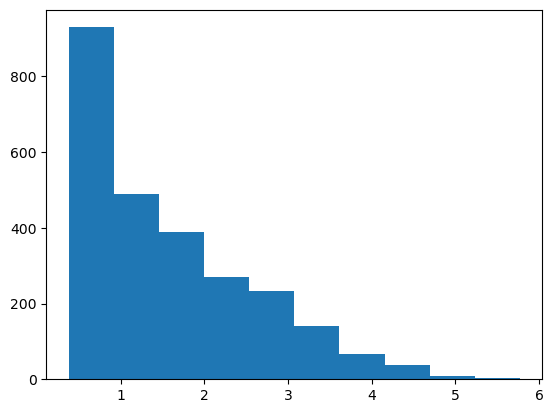

In [77]:
plt.hist(np.log10(c7_astropy['webdirtyDR']))

In [78]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [79]:
result_tos_mous_mit = wsu_db.join_wsu_and_mit_dbs(result_tos_mous, c7_astropy)

In [80]:
result_tos_mous_mit

mous,proposal_id,gous,schedblock_name,array,science_keyword,scientific_category_proposal,scientific_category,nant_typical,nant_array,nant_all,band,ntarget,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_nchan_agg_finest_early,wsu_nchan_agg_finest_later_2x,wsu_nchan_agg_finest_later_4x,wsu_nchan_agg_stepped_early,wsu_nchan_agg_stepped_later_2x,wsu_nchan_agg_stepped_later_4x,wsu_nchan_agg_stepped2_early,wsu_nchan_agg_stepped2_later_2x,wsu_nchan_agg_stepped2_later_4x,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,L80,Project,SB_name,blc_tint,blc_ntunings,bp_time,flux_time,phase_time,pol_time,check_time,target_time_tot,time_tot,cal_time,mfssize,wsu_cubesize_stepped2,wsu_productsize_early_stepped2,wsu_datarate_early_stepped2_typical,wsu_visrate_early_stepped2_typical,wsu_datavol_early_stepped2_typical_target_tot,wsu_datavol_early_stepped2_typical_cal,wsu_datavol_early_stepped2_typical_total,wsu_nvis_early_stepped2_typical_target_tot,wsu_nvis_early_stepped2_typical_cal,wsu_nvis_early_stepped2_typical_total,blc_datarate_typical,blc_visrate_typical,blc_datavol_typical_target_tot,blc_datavol_typical_cal,blc_datavol_typical_total,blc_nvis_typical_target_tot,blc_nvis_typical_cal,blc_nvis_typical_total,wsu_datarate_early_stepped2_array,wsu_visrate_early_stepped2_array,wsu_datavol_early_stepped2_array_target_tot,wsu_datavol_early_stepped2_array_cal,wsu_datavol_early_stepped2_array_total,wsu_nvis_early_stepped2_array_target_tot,wsu_nvis_early_stepped2_array_cal,wsu_nvis_early_stepped2_array_total,blc_datarate_array,blc_visrate_array,blc_datavol_array_target_tot,blc_datavol_array_cal,blc_datavol_array_total,blc_nvis_array_target_tot,blc_nvis_array_cal,blc_nvis_array_total,wsu_productsize_later_2x_stepped2,wsu_datarate_later_2x_stepped2_typical,wsu_visrate_later_2x_stepped2_typical,wsu_datavol_later_2x_stepped2_typical_target_tot,wsu_datavol_later_2x_stepped2_typical_cal,wsu_datavol_later_2x_stepped2_typical_total,wsu_nvis_later_2x_stepped2_typical_target_tot,wsu_nvis_later_2x_stepped2_typical_cal,wsu_nvis_later_2x_stepped2_typical_total,wsu_datarate_later_2x_stepped2_array,wsu_visrate_later_2x_stepped2_array,wsu_datavol_later_2x_stepped2_array_target_tot,wsu_datavol_later_2x_stepped2_array_cal,wsu_datavol_later_2x_stepped2_array_total,wsu_nvis_later_2x_stepped2_array_target_tot,wsu_nvis_later_2x_stepped2_array_cal,wsu_nvis_later_2x_stepped2_array_total,wsu_productsize_later_4x_stepped2,wsu_datarate_later_4x_stepped2_typical,wsu_visrate_later_4x_stepped2_typical,wsu_datavol_later_4x_stepped2_typical_target_tot,wsu_datavol_later_4x_stepped2_typical_cal,wsu_datavol_later_4x_stepped2_typical_total,wsu_nvis_later_4x_stepped2_typical_target_tot,wsu_nvis_later_4x_stepped2_typical_cal,wsu_nvis_later_4x_stepped2_typical_total,wsu_datarate_later_4x_stepped2_array,wsu_visrate_later_4x_stepped2_array,wsu_datavol_later_4x_stepped2_array_target_tot,wsu_datavol_later_4x_stepped2_array_cal,wsu_datavol_later_4x_stepped2_array_total,wsu_nvis_later_4x_stepped2_array_target_tot,wsu_nvis_later_4x_stepped2_array_cal,wsu_nvis_later_4x_stepped2_array_total,blc_cubesize,blc_cubesize_sum,blc_productsize,cycle_info,plversion,procedure,nant,pl_totaltime,pl_imgtime,pl_cubetime,pl_aggtime,pl_fctime,nEB,npt,nscan,reptgt,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw

In [81]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [82]:
c8_pickle = '/Users/akepley/Dropbox/Support/naasc/WSU/mitigation/weblog_stats/cycle8_stats.ignacio.20230103.pkl'
c8_astropy = wsu_db.get_pipeinfo(c8_pickle)

In [83]:
result_c8_tos_mous_mit = wsu_db.join_wsu_and_mit_dbs(result_c8_tos_mous, c8_astropy)

In [84]:
result_c8_tos_mous_mit

mous,proposal_id,gous,schedblock_name,array,science_keyword,scientific_category_proposal,scientific_category,nant_typical,nant_array,nant_all,band,ntarget,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_nchan_agg_finest_early,wsu_nchan_agg_finest_later_2x,wsu_nchan_agg_finest_later_4x,wsu_nchan_agg_stepped_early,wsu_nchan_agg_stepped_later_2x,wsu_nchan_agg_stepped_later_4x,wsu_nchan_agg_stepped2_early,wsu_nchan_agg_stepped2_later_2x,wsu_nchan_agg_stepped2_later_4x,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,L80,Project,SB_name,blc_tint,blc_ntunings,bp_time,flux_time,phase_time,pol_time,check_time,target_time_tot,time_tot,cal_time,mfssize,wsu_cubesize_stepped2,wsu_productsize_early_stepped2,wsu_datarate_early_stepped2_typical,wsu_visrate_early_stepped2_typical,wsu_datavol_early_stepped2_typical_target_tot,wsu_datavol_early_stepped2_typical_cal,wsu_datavol_early_stepped2_typical_total,wsu_nvis_early_stepped2_typical_target_tot,wsu_nvis_early_stepped2_typical_cal,wsu_nvis_early_stepped2_typical_total,blc_datarate_typical,blc_visrate_typical,blc_datavol_typical_target_tot,blc_datavol_typical_cal,blc_datavol_typical_total,blc_nvis_typical_target_tot,blc_nvis_typical_cal,blc_nvis_typical_total,wsu_datarate_early_stepped2_array,wsu_visrate_early_stepped2_array,wsu_datavol_early_stepped2_array_target_tot,wsu_datavol_early_stepped2_array_cal,wsu_datavol_early_stepped2_array_total,wsu_nvis_early_stepped2_array_target_tot,wsu_nvis_early_stepped2_array_cal,wsu_nvis_early_stepped2_array_total,blc_datarate_array,blc_visrate_array,blc_datavol_array_target_tot,blc_datavol_array_cal,blc_datavol_array_total,blc_nvis_array_target_tot,blc_nvis_array_cal,blc_nvis_array_total,wsu_productsize_later_2x_stepped2,wsu_datarate_later_2x_stepped2_typical,wsu_visrate_later_2x_stepped2_typical,wsu_datavol_later_2x_stepped2_typical_target_tot,wsu_datavol_later_2x_stepped2_typical_cal,wsu_datavol_later_2x_stepped2_typical_total,wsu_nvis_later_2x_stepped2_typical_target_tot,wsu_nvis_later_2x_stepped2_typical_cal,wsu_nvis_later_2x_stepped2_typical_total,wsu_datarate_later_2x_stepped2_array,wsu_visrate_later_2x_stepped2_array,wsu_datavol_later_2x_stepped2_array_target_tot,wsu_datavol_later_2x_stepped2_array_cal,wsu_datavol_later_2x_stepped2_array_total,wsu_nvis_later_2x_stepped2_array_target_tot,wsu_nvis_later_2x_stepped2_array_cal,wsu_nvis_later_2x_stepped2_array_total,wsu_productsize_later_4x_stepped2,wsu_datarate_later_4x_stepped2_typical,wsu_visrate_later_4x_stepped2_typical,wsu_datavol_later_4x_stepped2_typical_target_tot,wsu_datavol_later_4x_stepped2_typical_cal,wsu_datavol_later_4x_stepped2_typical_total,wsu_nvis_later_4x_stepped2_typical_target_tot,wsu_nvis_later_4x_stepped2_typical_cal,wsu_nvis_later_4x_stepped2_typical_total,wsu_datarate_later_4x_stepped2_array,wsu_visrate_later_4x_stepped2_array,wsu_datavol_later_4x_stepped2_array_target_tot,wsu_datavol_later_4x_stepped2_array_cal,wsu_datavol_later_4x_stepped2_array_total,wsu_nvis_later_4x_stepped2_array_target_tot,wsu_nvis_later_4x_stepped2_array_cal,wsu_nvis_later_4x_stepped2_array_total,blc_cubesize,blc_cubesize_sum,blc_productsize,cycle_info,plversion,procedure,nant,pl_totaltime,pl_imgtime,pl_cubetime,pl_aggtime,pl_fctime,nEB,npt,nscan,reptgt,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw

In [85]:
idx = result_tos_mous_mit['schedblock_name'] == 'MACS0454_a_06_TM1'
result_tos_mous_mit[idx]['proposal_id','mous','schedblock_name','array']

proposal_id,mous,schedblock_name,array
str14,str22,str18,str3
2019.1.00003.S,uid://A001/X1470/X2e3,MACS0454_a_06_TM1,12m


## calculating the required system performance

Everything including wproject and aproject

In [86]:
reload(wsu_db)
wsu_db.calc_sysperf(result_tos_mous_mit,
                    label='allgrid',
                    mosaic_aproject=True,
                    wproject=True)

In [87]:
wsu_db.calc_sysperf(result_c8_tos_mous_mit,
                    label='allgrid',
                    mosaic_aproject=True,
                    wproject=True)

Only aproject for mosaics

In [88]:
wsu_db.calc_sysperf(result_tos_mous_mit,
                    label='aprojonly',
                    mosaic_aproject=True,
                    wproject=False)

In [89]:
wsu_db.calc_sysperf(result_c8_tos_mous_mit,
                    label='aprojonly',
                    mosaic_aproject=True,
                    wproject=False)

In [90]:
result_tos_mous_mit.columns

<TableColumns names=('mous','proposal_id','gous','schedblock_name','array','science_keyword','scientific_category_proposal','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x',

In [91]:
result_c8_tos_mous_mit.columns

<TableColumns names=('mous','proposal_id','gous','schedblock_name','array','science_keyword','scientific_category_proposal','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_nchan_agg_finest_early','wsu_nchan_agg_finest_later_2x','wsu_nchan_agg_finest_later_4x','wsu_nchan_agg_stepped_early','wsu_nchan_agg_stepped_later_2x',

## Writing out the final file

In [92]:
# per MOUS/src
result_tos.write('data/wsu_datarates_per_mous_src_cycle7_20240315_gous.ecsv',overwrite=True)
result_c8_tos.write('data/wsu_datarates_per_mous_src_cycle8_20240315_gous.ecsv',overwrite=True)

In [93]:
# per MOUS
result_tos_mous_mit.write('data/wsu_datarates_mit_per_mous_cycle7_20240315_gous.ecsv',overwrite=True)
result_c8_tos_mous_mit.write('data/wsu_datarates_mit_per_mous_cycle8_20240315_gous.ecsv',overwrite=True)

# Writing out final file excluding Band 3, full pol, nbin=3 projects

In [94]:
idx = (result_tos['band'] == 3.0) & (result_tos['wsu_chanavg_stepped2'] == 3) & (result_tos['wsu_npol'] == 4)
print(np.unique(result_tos[idx]['mous']))
result_tos[idx]['mous','band','wsu_chanavg_stepped2','wsu_npol','wsu_datarate_early_stepped2_typical']

         mous         
----------------------
uid://A001/X1465/X1537
 uid://A001/X1465/X1c6
uid://A001/X1465/X1c94
uid://A001/X1465/X1c9c
uid://A001/X1465/X1ca0
uid://A001/X1465/X2dd9
uid://A001/X1465/X3856


mous,band,wsu_chanavg_stepped2,wsu_npol,wsu_datarate_early_stepped2_typical
,,,,Gbyte / s
str22,float64,float64,int64,float64
uid://A001/X1465/X1537,3.0,3.0,4,2.320954
uid://A001/X1465/X1537,3.0,3.0,4,2.320954
uid://A001/X1465/X1c6,3.0,3.0,4,2.320954
uid://A001/X1465/X1c94,3.0,3.0,4,2.320954
uid://A001/X1465/X1c9c,3.0,3.0,4,2.320954
uid://A001/X1465/X1c9c,3.0,3.0,4,2.320954
uid://A001/X1465/X1ca0,3.0,3.0,4,2.320954
uid://A001/X1465/X1ca0,3.0,3.0,4,2.320954


In [95]:
idx = (result_c8_tos['band'] == 3) &(result_c8_tos['wsu_chanavg_stepped2'] == 3) & (result_c8_tos['wsu_npol'] == 4)
print(np.unique(result_c8_tos[idx]['mous']))
result_c8_tos[idx]['mous','band','wsu_chanavg_stepped2','wsu_npol','wsu_datarate_early_stepped2_typical']

         mous        
---------------------
uid://A001/X158f/X814


mous,band,wsu_chanavg_stepped2,wsu_npol,wsu_datarate_early_stepped2_typical
,,,,Gbyte / s
str22,float64,float64,int64,float64
uid://A001/X158f/X814,3.0,3.0,4,2.320954


Don't need to do this any more since the problematic cases are removed.

In [96]:
idx = (result_tos['band'] == 3) &(result_tos['wsu_chanavg_stepped2'] == 3) & (result_tos['wsu_npol'] == 4)
print(np.sum(idx))
idx_opp = np.invert(idx)
print(np.sum(idx_opp))
print(len(idx))

18
11501
11519


In [97]:
idx = (result_c8_tos['band'] == 3) & (result_c8_tos['wsu_chanavg_stepped2'] == 3) & (result_c8_tos['wsu_npol'] == 4)
print(np.sum(idx))
idx_opp = np.invert(idx)
print(np.sum(idx_opp))
print(len(idx))

1
10842
10843


In [98]:
idx = (result_tos_mous_mit['band'] == 3) & (result_tos_mous_mit['wsu_chanavg_stepped2'] == 3) & (result_tos_mous_mit['wsu_npol'] == 4)
print(np.sum(idx))
idx_opp = np.invert(idx)
print(np.sum(idx_opp))
print(len(idx))

7
2712
2719


In [99]:
idx = (result_c8_tos_mous_mit['band'] == 3) & (result_c8_tos_mous_mit['wsu_chanavg_stepped2'] == 3) & (result_c8_tos_mous_mit['wsu_npol'] == 4)
print(np.sum(idx))
idx_opp = np.invert(idx)
print(np.sum(idx_opp))
print(len(idx))

1
2480
2481


In [137]:
idx = (result_tos['band'] == 3) &  (result_tos['wsu_chanavg_stepped2'] == 3) & (result_tos['wsu_npol'] == 4)
idx_opp = np.invert(idx)
(result_tos[idx_opp]).write('data/wsu_datarates_per_mous_src_cycle7_20240315_gous_without_band3_nbin3_npol4.ecsv',overwrite=True)

In [100]:
idx = (result_c8_tos['band'] == 3) & (result_c8_tos['wsu_chanavg_stepped2'] == 3) & (result_c8_tos['wsu_npol'] == 4)
idx_opp = np.invert(idx)
(result_c8_tos[idx_opp]).write('data/wsu_datarates_per_mous_src_cycle8_20240315_gous_without_band3_nbin3_npol4.ecsv',overwrite=True)

In [101]:
idx = (result_tos_mous_mit['band'] == 3) & (result_tos_mous_mit['wsu_chanavg_stepped2'] == 3) & (result_tos_mous_mit['wsu_npol'] == 4)
idx_opp = np.invert(idx)
result_tos_mous_mit[idx_opp].write('data/wsu_datarates_mit_per_mous_cycle7_20240315_gous_without_band3_nbin3_npol4.ecsv',
                                   overwrite=True)

In [102]:
idx = (result_c8_tos_mous_mit['band'] == 3) & (result_c8_tos_mous_mit['wsu_chanavg_stepped2'] == 3) & (result_c8_tos_mous_mit['wsu_npol'] == 4)
idx_opp = np.invert(idx)
result_c8_tos_mous_mit[idx_opp].write('data/wsu_datarates_mit_per_mous_cycle8_20240315_gous_without_band3_nbin3_npol4.ecsv',overwrite=True)

### figure out masking

In [ ]:
test = result_tos_mous_mit['pl_imgtime']/result_tos_mous_mit['pl_totaltime']

In [ ]:
plt.hist(test)

## Figuring out how to factor in spectral scans

Below are some experiments

In [ ]:
idx = result_c8_tos['proposal_id'] == '2021.1.00917.S'
result_c8_tos['proposal_id','target_name','blc_nspw'][idx].show_in_browser()

In [ ]:
idx = (result_c8_tos['blc_nspw'] == 20) | (result_c8_tos['blc_nspw'] == 16)
result_c8_tos['proposal_id','target_name','blc_nspw'][idx].show_in_browser()

## Adding in BLC int

This is a failed experiment below. The data table had the information I needed, but not for the problems in my sample.

In [ ]:
# this data file might ahve what I need.
blc_info = Table.read('data/sb_science_targets_consolidated_bl.csv')

In [ ]:
blc_info.columns

In [ ]:
blc_info['OBSPROJECT_UID','SB_UID','SB_NAME','FIELD_SOURCE_NAME','BLSPEC_INTEGRATION_DURATION']

 But it doesn't look liek there's overlap between my sample and this file.

In [ ]:
plt.hist(blc_info['BLSPEC_INTEGRATION_DURATION'])

But the times are either 6 or 2

## Mosaic imsize investigation

This isn't needed for calculation. It was used to figure out what prefix factor I needed for imsizes.

In [ ]:
idx = (result['mosaic'] == 'T') & (result['imsize'] >5800)
result['mous','imsize','cell','s_fov','s_resolution','wsu_freq','pb','mosaic'][idx]

In [ ]:
0.01056278408537675 *3600.0  

Image pre-check values for  2019.1.00796.S, uid://A001/X1471/X317	

* beam = 0.0457 x 0.0404 arcsec
* cell = 0.0081 x 0.0081 arcsec

Unmitigated imsize calculated in pipeline for X317 is 7776, 7776 according to SCG tests

eye balling the spatial set up it looks like there's 10-12arcsec between pointings and the plot says the primary beam is 26.0arcsec

The pipeline math is   

npts <= 3
* nxpix = int((1.65 * beam_radius_v + xspread) / cellx_v)

npts >3
* nxpix = int((1.5 * beam_radius_v + xspread) / cellx_v)

We only have two pointings here.



In [ ]:
(26.0 + 10.0)

In [ ]:
(1.65 * 26.0 + 10.0)/0.0081

So my estimate is a little on the low end, but not crazy

In [ ]:
(0.01044*3600+25.6*0.70)/0.0072

## Imsize investigation

Something is  odd with my image sizes. I'm using 2019.1.01463.S uid://A001/X1465/Xc05 as my poster child

For the unmitigated imaging done by the pipeline, the pipeline calculates the following values:
* beam: 0.0322" x 0.0211"
* cell: 0.0042" x 0.0042"
* imsize: [11250, 11250] pixels
* FOV: 47.25 arcsec

Now let's look at what I get from my calculations

In [ ]:
#2019.1.01463.S
idx =result['mous'] == 'uid://A001/X1465/Xc05'
result['mous','s_fov','s_resolution','imsize','wsu_nchan_final_stepped','wsu_nchan_final_finest','mosaic'][idx]

In [ ]:
np.log10(237037.03703703705)

In [ ]:
np.log10(32921.81069958848)

In [ ]:
# the imsize is
0.007157768473981626*3600.00 # arcsec

In [ ]:
# What's the estimated imsize at this frequency??
# frequency
freq = 218.821 #GHz
19.4*300/218.821

This is comparable to the imsize calculated above.

In [ ]:
# What pixel size does this imply for five pixels per beam?
0.024588/5.0

In [ ]:
# What pixel size does this imply for six pixels per beam?
0.024588/6.0

What happens if I use the points_per_fov value??

In [ ]:
idx2 = cycle7tab['member_ous_uid'] == 'uid://A001/X1465/Xc05'
cycle7tab['proposal_id','member_ous_uid','s_fov','s_resolution','points_per_fov','spw_nchan','is_mosaic'][idx2]

In [ ]:
# imsize from points per fov value
np.sqrt(1100957.4775723005)*5.0

Matches imsize above.

So it looks like the FOV is the difference:

In [ ]:
(47.25/25.76)*5250

Still an underestimate, but closer.

The pipeline calculates the primary beam as

primary_beam_size = \
            1.22 \
            * cqa.getvalue(cqa.convert(cqa.constants('c'), 'm/s')) \
            / ref_frequency \
            / smallest_diameter \
            * (180.0 * 3600.0 / math.pi)

In [ ]:
1.22 * ((const.c.value /  218.821e9) / (12.0) )*(180*3600.0/math.pi)

Pipeline calculation is here:

beam_radius_v = primary_beam

beam_fwhp = 1.12 / 1.22 * beam_radius_v

nxpix = int(utils.round_half_up(1.1 * beam_fwhp * math.sqrt(-math.log(sfpblimit) / math.log(2.)) / cellx_v))

In [ ]:
(1.12/1.22)* 28.73

In [ ]:
1.1 * 26.38 * math.sqrt(-math.log(0.2) / math.log(2.0))

Okay. This is the value I get above. 

What's the constant??

In [ ]:
1.1* (1.12/1.22)*math.sqrt(-math.log(0.2) / math.log(2.0))

In [ ]:
1.54*25.8

In [ ]:
40.0/0.0040